# Import libraries

In [1]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import sys
from pathlib import Path
import requests
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath("../"))

from helpers.df_formating import (
    convert_to_integer, 
    convert_cols_to_snake_case,
    normalize,
    drop_row_if_not_complete, 
    drop_if_unnamed, 
    excel_time_to_minutes)
from helpers.geo_coding import prepare_village_for_geocoding, geocode_place_mapbox_v5, geocode_unique_queries_mapbox

def to_analyze(df, cols):
    to_analyze = df[cols]
    path_desktop = "/mnt/c/Users/matth/Desktop"
    path_file = f"{path_desktop}/to_analyze.csv"
    to_analyze.to_csv(path_file, index=False)

def is_only_id_columns(df: pd.DataFrame):
    id_keywords = ("id", "number", "#", "nr", "no")
    cols = [c.lower() for c in df.columns]
    return all(
        any(k in col for k in id_keywords)
        for col in cols
    )

def drop_sparse_columns_or_skip(
    df: pd.DataFrame,
    empty_threshold: float = 0.95,
    treat_whitespace_as_empty: bool = True,
    also_treat_strings_as_na: tuple[str, ...] = ("na", "n/a", "null", "none", "")
):
    if df is None or df.empty:
        return None

    work = df.copy()

    if treat_whitespace_as_empty:
        work = work.replace(r"^\s+$", np.nan, regex=True)

    if also_treat_strings_as_na:
        na_set = set(s.lower() for s in also_treat_strings_as_na)
        work = work.applymap(
            lambda x: np.nan
            if isinstance(x, str) and x.strip().lower() in na_set
            else x
        )

    if work.isna().to_numpy().all():
        return None

    # Drop columns with >95% missing
    missing_frac = work.isna().mean(axis=0)
    cols_to_drop = missing_frac[missing_frac > empty_threshold].index
    work = work.drop(columns=cols_to_drop)

    # If nothing meaningful remains -> skip
    if work.shape[1] == 0 or work.isna().to_numpy().all():
        return None

    # ✅ NOW check if remaining columns are only IDs
    if is_only_id_columns(work):
        return None

    return work

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # strip whitespace from headers
    df.columns = df.columns.astype(str).str.strip()

    # collapse repeated spaces
    df.columns = df.columns.str.replace(r"\s+", " ", regex=True)

    # fix common typos / variants (add more as you find them)
    rename_map = {
        "Sarting time": "Starting time",
        "Anaestesist": "Anaesthetist",
        "1st Assistent/Instructor": "1st Assistant/Instructor",
        "1st Assistent/Instructor ": "1st Assistant/Instructor",
    }
    df = df.rename(columns=rename_map)

    return df

In [2]:
base_dir ="Nkhoma_data/Data"

In [3]:
filtered = [
    f for f in os.listdir(base_dir)
    if "clean" not in f.lower()
    and "ipynb_checkpoints" not in f.lower()
]
filtered

['Theatre_Book-Database 2025-plain.xlsx',
 'Old Theatre Books.xlsx',
 'Theatre_Book-Database 2022 Auswertung-Arbeitsversion.xlsx',
 'Theatre_Book-Database 2024 Auswertung-Arbeitsversion.xlsx',
 'Theatre_Book-Database 2023 Auswertung-Arbeitsversion.xlsx']

In [4]:
dfs = []

for file in filtered:
    path = f"{base_dir}/{file}"
    df = pd.read_excel(path, engine="openpyxl")

    # skip if Theatre Book column is missing (based on first column header)
    first_col = df.columns[0]
    if "theatre book" not in str(first_col).lower():
        print(f"Skipping {file}: no Theatre Book column")
        continue

    # normalize the ID column name FIRST
    df = df.rename(columns={first_col: "theatre_book_index"})

    # clean sparse columns / empty sheets
    df = drop_sparse_columns_or_skip(df, empty_threshold=0.95)
    if df is None:
        print(f"Skipping {file}: empty after cleaning.")
        continue

    # numeric + valid ID rows only
    df["theatre_book_index"] = pd.to_numeric(df["theatre_book_index"], errors="coerce")
    df = df.dropna(subset=["theatre_book_index"])

    # keep only exactly 6-digit IDs
    df = df[df["theatre_book_index"].astype(int).astype(str).str.fullmatch(r"\d{6}")]

    df = normalize_columns(df)
    clean = drop_sparse_columns_or_skip(df, empty_threshold=0.95)
    if clean is None:
        print(f"Skipping {file}: empty after cleaning.")
        continue

    if list(clean.columns) == ["theatre_book_index"]:
        print(f"Skipping {file}: only theatre_book_index column left")
        continue


    dfs.append(clean)

result = pd.concat(dfs, axis=0, ignore_index=True)


/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/tmp/ipykernel_7816/3591367237.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  work = work.applymap(
/tmp/ipykernel_7816/3591367237.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  work = work.applymap(


Skipping Theatre_Book-Database 2025-plain.xlsx: only theatre_book_index column left
Skipping Old Theatre Books.xlsx: no Theatre Book column


/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/tmp/ipykernel_7816/3591367237.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  work = work.applymap(
/tmp/ipykernel_7816/3591367237.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  work = work.applymap(
/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/tmp/ipykernel_7816/3591367237.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  work = work.applymap(
/tmp/ipykernel_7816/3591367237.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `res

In [5]:
# ensure string for regex check
idx = result["theatre_book_index"].astype(str).str.strip()

# keep only exactly 6-digit IDs
#result = result[idx.str.fullmatch(r"\d{6}")].copy()

# make it integer again
result["theatre_book_index"] = result["theatre_book_index"].astype(int)
result = convert_cols_to_snake_case(result)

# convert date_of_surgery to datetime
result["date_of_surgery"] = pd.to_datetime(
    result["date_of_surgery"],
    errors="coerce"
)

In [6]:
import pandas as pd
import numpy as np

def normalize_theatre_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- 1) Dates ---
    if "date_of_surgery" in out.columns:
        out["date_of_surgery"] = pd.to_datetime(out["date_of_surgery"], errors="coerce")

    # --- 2) Identify text columns and standardize whitespace/case ---
    text_cols = out.select_dtypes(include=["object", "string"]).columns

    def clean_text(s: pd.Series) -> pd.Series:
        s = s.astype("string")

        # unify empties and common placeholders to missing
        s = s.replace(
            {
                "": pd.NA,
                "NA": pd.NA, "N/A": pd.NA, "na": pd.NA,
                "null": pd.NA, "None": pd.NA, "none": pd.NA,
                "nan": pd.NA, "NaN": pd.NA,
            }
        )

        # trim + collapse internal whitespace
        s = s.str.strip()
        s = s.str.replace(r"\s+", " ", regex=True)
        return s

    for c in text_cols:
        out[c] = clean_text(out[c])

    # --- 3) Normalize key categorical fields (edit/extend as needed) ---
    if "sex" in out.columns:
        out["sex"] = (
            out["sex"]
            .str.upper()
            .replace({"FEMALE": "F", "MALE": "M"})
        )
        out.loc[~out["sex"].isin(["F", "M"]), "sex"] = pd.NA

    if "urgency" in out.columns:
        out["urgency"] = out["urgency"].str.title()
        out["urgency"] = out["urgency"].replace(
            {"Emerg": "Emergency", "Elective ": "Elective"}
        )

    if "histology" in out.columns:
        # Keep as Yes/No/NA (handles NO/No/YES/etc)
        out["histology"] = out["histology"].str.strip().str.upper()
        out["histology"] = out["histology"].replace(
            {"YES": "Yes", "Y": "Yes", "NO": "No", "N": "No"}
        )
        out.loc[~out["histology"].isin(["Yes", "No"]), "histology"] = pd.NA

    if "asascore" in out.columns:
        # Standardize variations like "ASA 3", "Asa3", "ASA3" -> "ASA 3"
        out["asascore"] = (
            out["asascore"]
            .str.upper()
            .str.replace(r"^ASA\s*([1-6])$", r"ASA \1", regex=True)
        )

    # --- 4) Normalize numeric columns that might be stored as text ---
    for c in ["age_years", "year_of_birth"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    for col in ["first_name", "last_name"]:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype("string")
                .str.strip()
                .str.lower()
                .str.title()
            )
    name_cols = [
        "surgeon",
        "first_assistant_instructor",
        "second_assistent",
        "anaesthetist",
        "nurse",
    ]
    
    for col in name_cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype("string")
                .str.strip()
                .str.lower()
                .str.title()
            )

    return out

In [7]:
result = normalize_theatre_df(result)
# df_clean.head()

In [8]:
rename_map = {
    # Obs/Gyn variants
    "obs/Gyn": "Obs/Gyn",
    "OBs/Gyn": "Obs/Gyn",

    # Other
    "other": "Other",

    # Lam
    "lam": "Lam",

    # Vitu
    "VITU": "Vitu",
    "vitu": "Vitu",

    # Stuebing misspellings
    "Steubing": "Stuebing",
    "Steubig": "Stuebing",
}

result["surgeon"] = result["surgeon"].replace(rename_map)
result["first_assistant_instructor"] = result["first_assistant_instructor"].replace(rename_map)
result["second_assistent"] = result["second_assistent"].replace(rename_map)

In [9]:
result.columns

Index(['theatre_book_index', 'date_of_surgery', 'first_name', 'last_name',
       'age_years', 'sex', 'village', 'surgeon', 'first_assistant_instructor',
       'anaesthetist', 'nurse', 'anesthesia', 'department',
       'indication_for_surgery', 'surgery_type', 'final_diagnosis_category',
       'final_diagnosis_free_text', 'side', 'main_procedure_category',
       'procedure_free_text', 'histology', 'starting_time', 'finishing_time',
       'urgency', 'surgery_severity', 'asascore', 'year_of_birth',
       'operation_time_minutes', 'second_assistent'],
      dtype='object')

In [10]:
df1 = result[['theatre_book_index','surgeon','main_procedure_category','date_of_surgery']]
df2 = result[['theatre_book_index', 'first_assistant_instructor','main_procedure_category','date_of_surgery']]
df2 = df2.rename(columns={"first_assistant_instructor": "surgeon"})
df3 = result[['theatre_book_index', 'second_assistent','main_procedure_category','date_of_surgery']]
df3 = df3.rename(columns={"second_assistent": "surgeon"})
df_all = pd.concat([df1, df2, df3], ignore_index=True)

In [11]:
df_all

,theatre_book_index,surgeon,main_procedure_category,date_of_surgery
0,220001,Obs/Gyn,C/S,2022-01-01
1,220002,Obs/Gyn,C/S,2022-01-01
2,220003,Obs/Gyn,C/S,2022-01-02
3,220004,Limbe,Other,2022-01-03
4,220005,Obs/Gyn,C/S,2022-01-03
...,...,...,...,...
17401,232130,<NA>,OTHer,2023-12-30
17402,232131,<NA>,Other,2023-12-31
17403,232132,<NA>,Other,2023-12-31
17404,232133,<NA>,Other,2023-12-31


In [12]:
df_all["procedure_label"] = pd.NA

mask_endoscopy = (
    df_all["main_procedure_category"]
    .astype("string")
    .str.lower()
    .str.contains(r"\begd\b|colonoscopy|coloscopy", regex=True, na=False)
)

df_all.loc[mask_endoscopy, "procedure_label"] = "Endoscopy"
df_all.loc[~mask_endoscopy, "procedure_label"] = "Surgery"

# optional: keep NA where main_procedure_category is NA
df_all.loc[df_all["main_procedure_category"].isna(), "procedure_label"] = pd.NA


In [13]:
df_all["surgeon_label"] = (
    df_all["surgeon"].astype("string")
    + "_"
    + df_all["procedure_label"].astype("string")
)

# Surgeries per surgeon

In [14]:
surgeries_per_surgeon = (
    df_all
    .dropna(subset=["surgeon_label"])
    .groupby("surgeon_label")
    .size()
    .reset_index(name="total_surgeries")
    .sort_values("total_surgeries", ascending=False)
)

In [15]:
surgeries_per_surgeon = surgeries_per_surgeon[
    ~surgeries_per_surgeon["surgeon_label"].isin(["Obs/Gyn", "Other"])
]
surgeries_per_surgeon[["surgeon", "type_of_procedure"]] = (
    surgeries_per_surgeon["surgeon_label"]
    .str.split("_", n=1, expand=True)
)

In [16]:
surgeries_per_surgeon = surgeries_per_surgeon[
    ~surgeries_per_surgeon["surgeon"].isin(["Obs/Gyn", "Other"])
]


In [17]:
surgeries_per_surgeon

,surgeon_label,total_surgeries,surgeon,type_of_procedure
7,Limbe_Surgery,531,Limbe,Surgery
21,Vitu_Surgery,499,Vitu,Surgery
1,Caleb_Surgery,471,Caleb,Surgery
23,Widmann_Surgery,419,Widmann,Surgery
6,Limbe_Endoscopy,385,Limbe,Endoscopy
5,Lam_Surgery,326,Lam,Surgery
25,Wongani_Surgery,296,Wongani,Surgery
9,Madalitso_Surgery,273,Madalitso,Surgery
17,Thoko_Surgery,259,Thoko,Surgery
4,Lam_Endoscopy,200,Lam,Endoscopy


In [18]:
# compute total per surgeon
total_df = (
    surgeries_per_surgeon
    .groupby("surgeon", as_index=False)["total_surgeries"]
    .sum()
)

total_df["type_of_procedure"] = "Total"
plot_df = pd.concat(
    [surgeries_per_surgeon, total_df],
    ignore_index=True
)

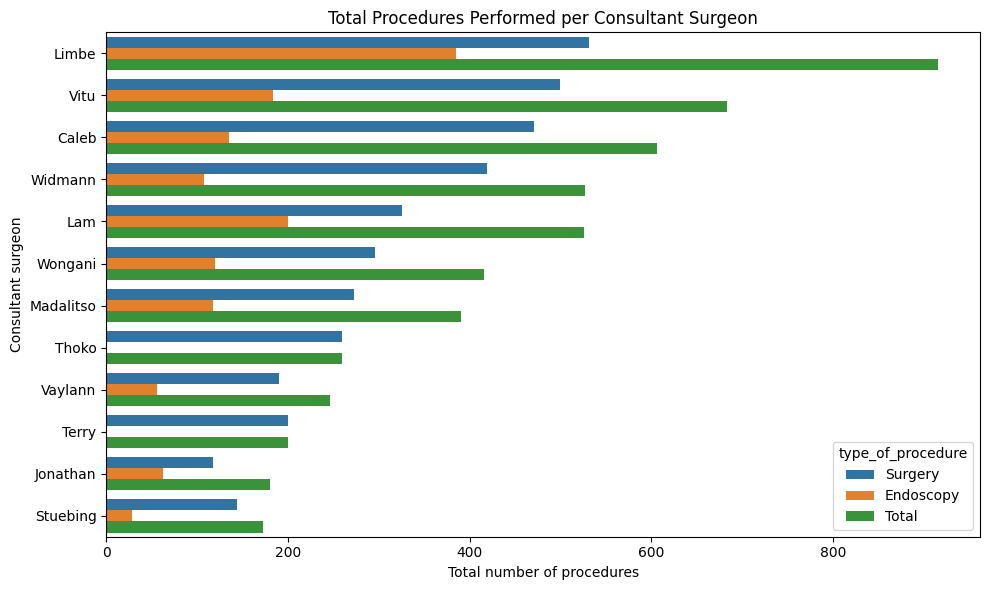

In [35]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=plot_df,
    y="surgeon",
    x="total_surgeries",
    hue="type_of_procedure",
    order=plot_df.groupby("surgeon")["total_surgeries"]
           .sum()
           .sort_values(ascending=False)
           .index,
)

plt.xlabel("Total number of procedures")
plt.ylabel("Consultant surgeon")
plt.title("Total Procedures Performed per Consultant Surgeon")

plt.tight_layout()
plt.savefig("procedures_performed_per_surgeon.png")

plt.show()


In [20]:
# extract year
df_filtered = df_all[
    ~df_all["surgeon"].isin(["Other", "Obs/Gyn"])
]
df_filtered["year"] = df_filtered["date_of_surgery"].dt.year

# count surgeries per year per surgeon
yearly_counts = (
    df_filtered
    .dropna(subset=["surgeon"])          # optional: drop missing surgeons
    .groupby(["year", "surgeon"])
    .size()
    .reset_index(name="n_surgeries")
)


/tmp/ipykernel_7816/4270623635.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["year"] = df_filtered["date_of_surgery"].dt.year


In [21]:
yearly_counts

,year,surgeon,n_surgeries
0,2022,Caleb,218
1,2022,Lam,227
2,2022,Limbe,253
3,2022,Madalitso,1
4,2022,Stuebing,72
5,2022,Terry,88
6,2022,Thoko,62
7,2022,Vaylann,45
8,2022,Vitu,238
9,2022,Widmann,78


In [22]:
names = list(yearly_counts["surgeon"].unique())

list_order = [
    "Limbe", "Vaylann", "Lam", "Stuebing", "Widmann",
    "Widmann", "Caleb", "Vitu", "Wongani",
    "Madalitso", "Jonathan", "Thoko", "Thoko", "Terry"
]

# remove duplicates, keep order, and keep only valid names
hue_order = []
for s in list_order:
    if s in names and s not in hue_order:
        hue_order.append(s)

hue_order


['Limbe',
 'Vaylann',
 'Lam',
 'Stuebing',
 'Widmann',
 'Caleb',
 'Vitu',
 'Wongani',
 'Madalitso',
 'Jonathan',
 'Thoko',
 'Terry']

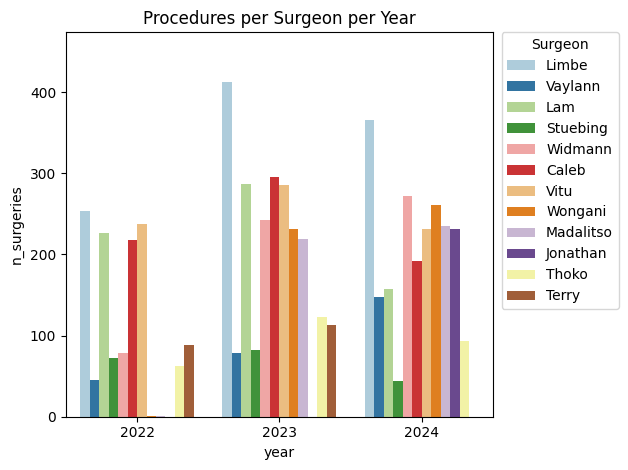

In [36]:
ax = sns.barplot(
    data=yearly_counts,
    x="year",
    y="n_surgeries",
    hue="surgeon",
    hue_order=hue_order,
    palette="Paired"
)

# add ~15% headroom
y_max = yearly_counts["n_surgeries"].max()
ax.set_ylim(0, y_max * 1.15)

ax.set_title("Procedures per Surgeon per Year")

plt.legend(
    title="Surgeon",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.savefig("procedures_per_surgeon_per_year.png", dpi=300, bbox_inches="tight")
plt.show()


In [24]:
names = list(yearly_counts.surgeon.unique())
list_order = ["Limbe", "Vaylann", "Lam", "Stuebing", "Widmann","Widmann","Caleb", "Vitu","Wongani", "Madalitso", "Jonathan", "Thoko", "Thoko","Terry"]

In [39]:
plot_df

,surgeon_label,total_surgeries,surgeon,type_of_procedure
0,Limbe_Surgery,531,Limbe,Surgery
1,Vitu_Surgery,499,Vitu,Surgery
2,Caleb_Surgery,471,Caleb,Surgery
3,Widmann_Surgery,419,Widmann,Surgery
4,Limbe_Endoscopy,385,Limbe,Endoscopy
5,Lam_Surgery,326,Lam,Surgery
6,Wongani_Surgery,296,Wongani,Surgery
7,Madalitso_Surgery,273,Madalitso,Surgery
8,Thoko_Surgery,259,Thoko,Surgery
9,Lam_Endoscopy,200,Lam,Endoscopy


In [37]:
yearly_counts

,year,surgeon,n_surgeries
0,2022,Caleb,218
1,2022,Lam,227
2,2022,Limbe,253
3,2022,Madalitso,1
4,2022,Stuebing,72
5,2022,Terry,88
6,2022,Thoko,62
7,2022,Vaylann,45
8,2022,Vitu,238
9,2022,Widmann,78


In [41]:
import numpy as np
import pandas as pd

# proportions per surgeon from plot_df (ignore the 'Total' rows if present)
type_totals = (
    plot_df[plot_df["type_of_procedure"].isin(["Surgery", "Endoscopy"])]
    .groupby(["surgeon", "type_of_procedure"], as_index=False)["total_surgeries"]
    .sum()
)

props = (
    type_totals
    .pivot(index="surgeon", columns="type_of_procedure", values="total_surgeries")
    .fillna(0)
)

# proportion of surgery for each surgeon (avoid divide-by-zero)
props["p_surgery"] = np.where(
    (props.get("Surgery", 0) + props.get("Endoscopy", 0)) > 0,
    props.get("Surgery", 0) / (props.get("Surgery", 0) + props.get("Endoscopy", 0)),
    np.nan
)

# merge proportions into yearly_counts
tmp = yearly_counts.merge(props["p_surgery"], left_on="surgeon", right_index=True, how="left")

# estimate split
tmp["n_surgery_est"] = (tmp["n_surgeries"] * tmp["p_surgery"]).round().astype("Int64")
tmp["n_endoscopy_est"] = (tmp["n_surgeries"] - tmp["n_surgery_est"]).astype("Int64")

# long format for plotting
yearly_type_counts_est = pd.concat([
    tmp[["year", "surgeon"]].assign(type_of_procedure="Surgery",  n_surgeries=tmp["n_surgery_est"]),
    tmp[["year", "surgeon"]].assign(type_of_procedure="Endoscopy", n_surgeries=tmp["n_endoscopy_est"]),
], ignore_index=True)


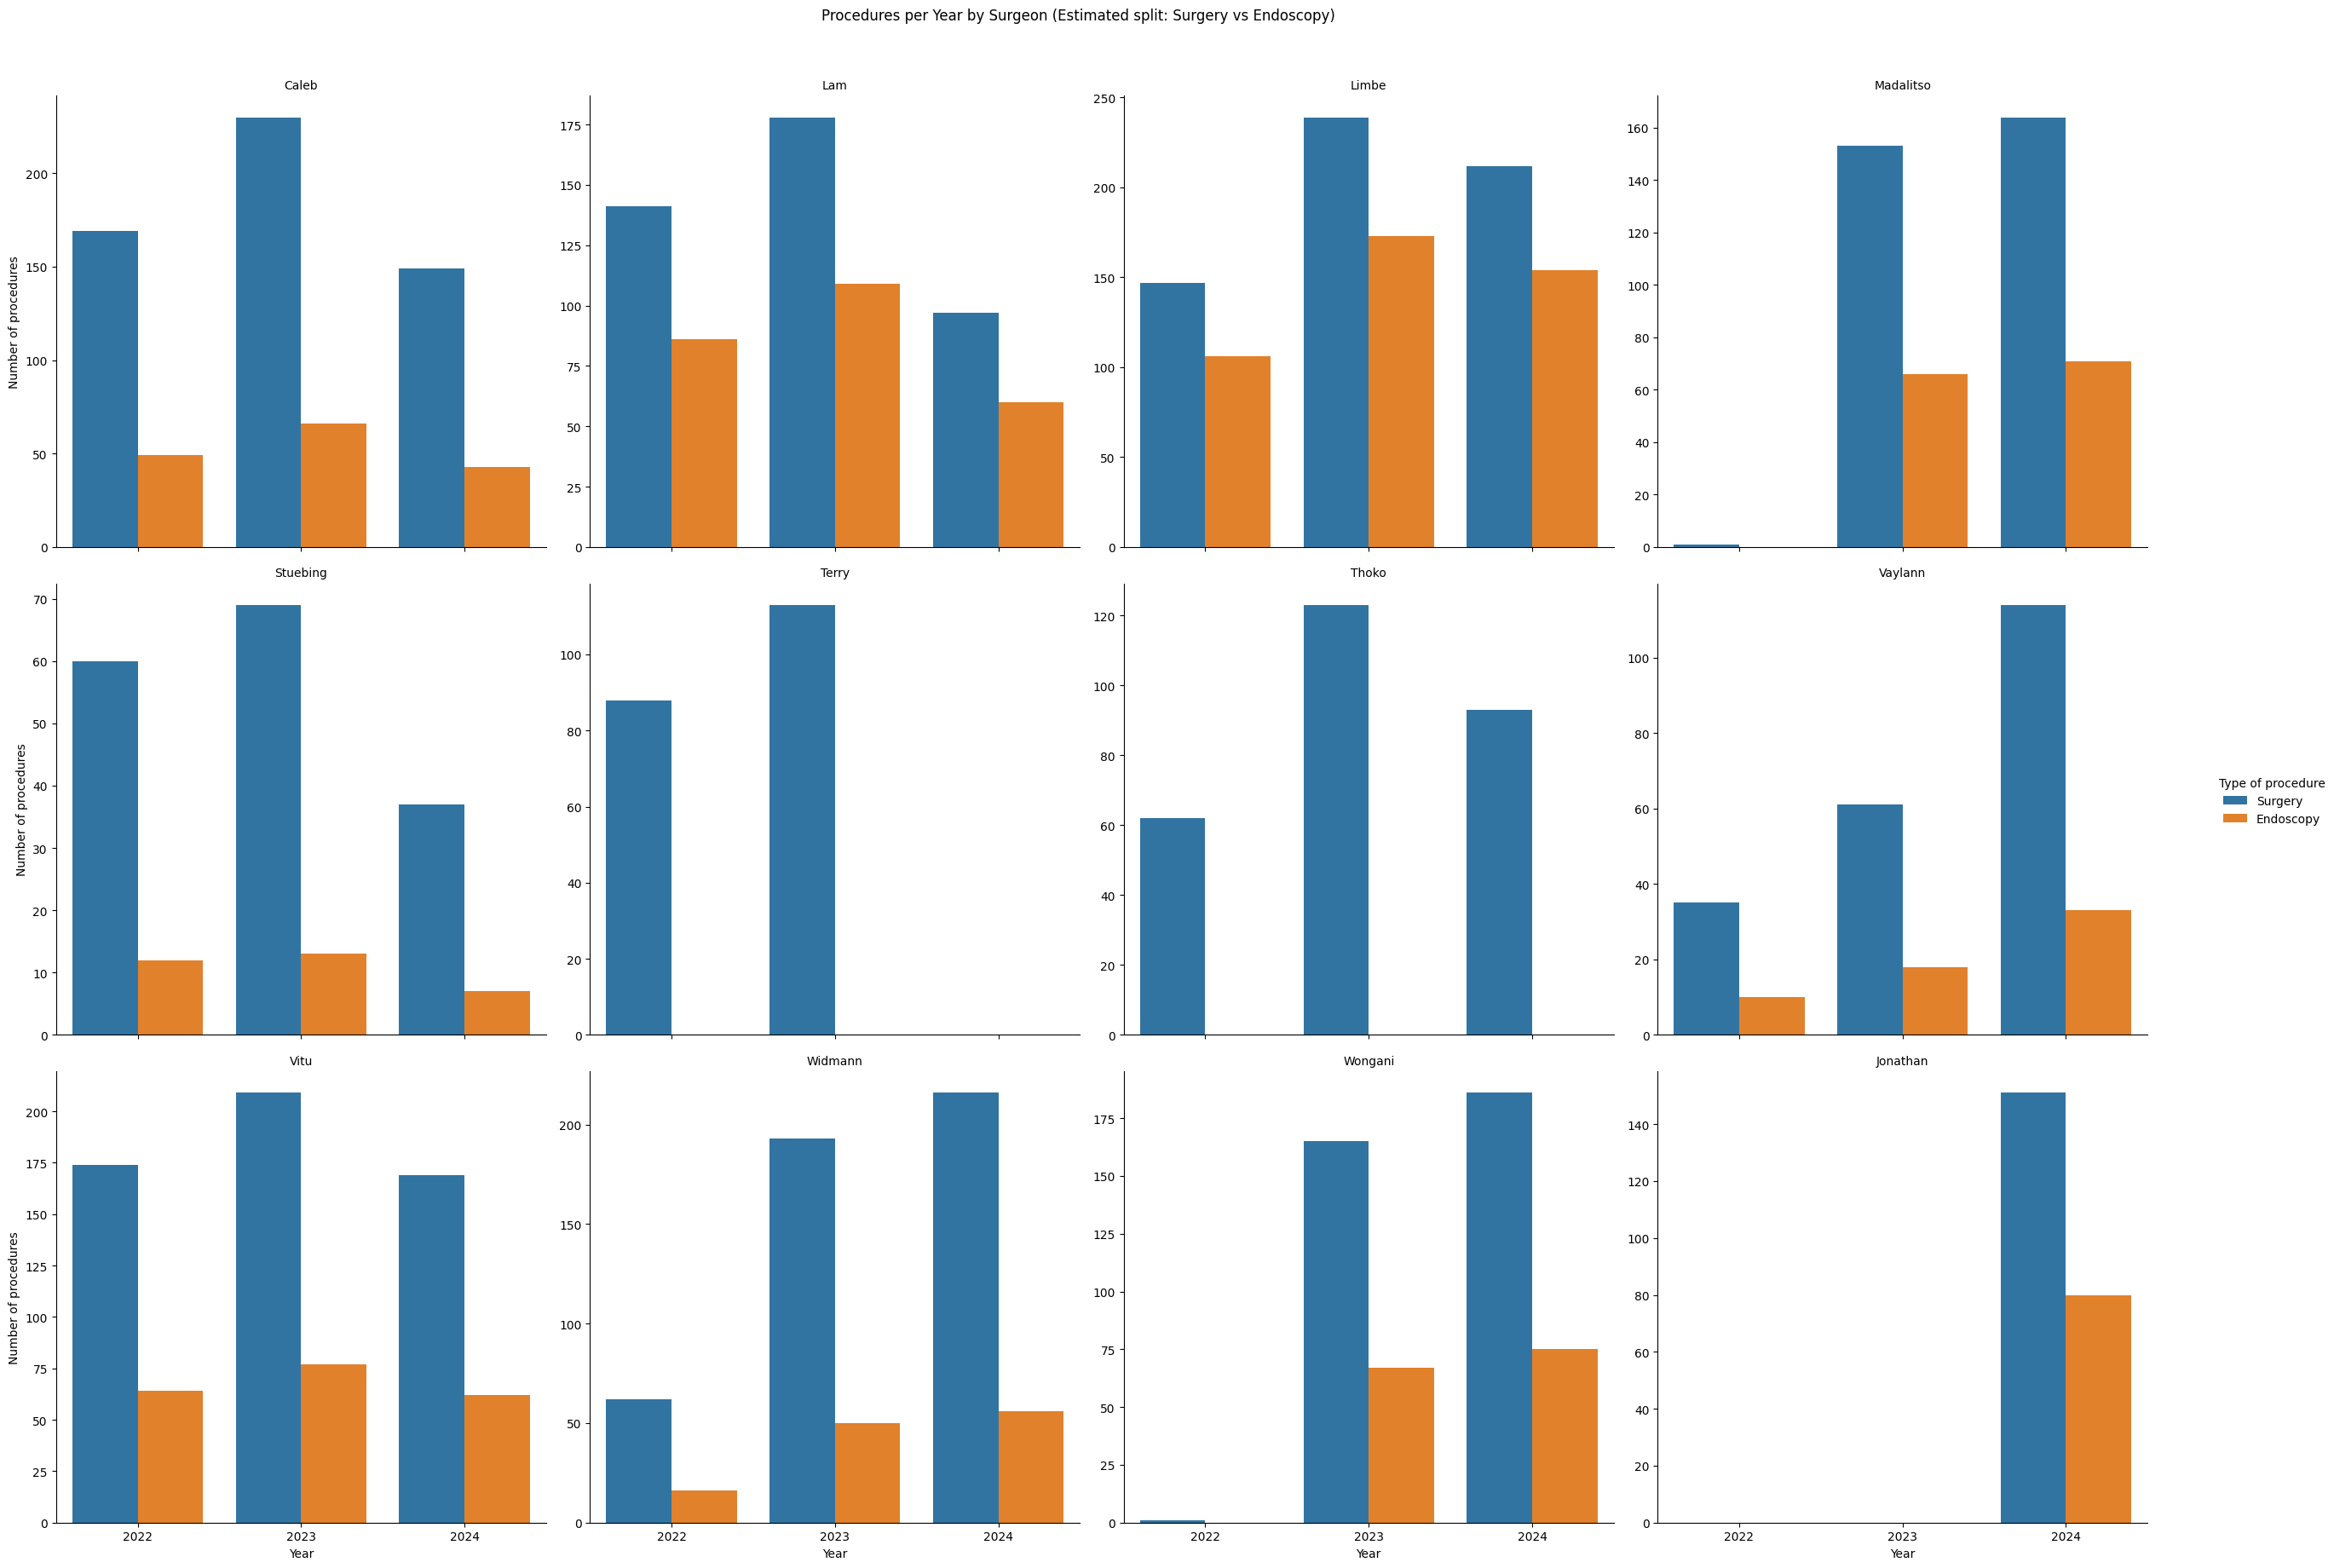

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=yearly_type_counts_est,
    x="year",
    y="n_surgeries",
    hue="type_of_procedure",
    col="surgeon",
    kind="bar",
    col_wrap=4,
    height=6,
    sharey=False
)

g.set_axis_labels("Year", "Number of procedures")
g.set_titles("{col_name}")

g.fig.suptitle("Procedures per Year by Surgeon (Estimated split: Surgery vs Endoscopy)", y=1.02)

# move legend outside
if g._legend is not None:
    g._legend.set_title("Type of procedure")
    g._legend.set_bbox_to_anchor((1.02, 0.5))
    g._legend.set_loc("center left")

plt.tight_layout()
plt.savefig("procedures_per_surgeon_per_year_by_type.png", dpi=300, bbox_inches="tight")
plt.show()


In [26]:
# extract year
result["year"] = pd.to_datetime(result["date_of_surgery"], errors="coerce").dt.year

surgeries_per_surgeon_year = (
    result
    .dropna(subset=["surgeon", "year"])
    .groupby(["surgeon", "year"])
    .size()
    .reset_index(name="surgeries")
)

# average surgeries per year per surgeon
avg_per_year = (
    surgeries_per_surgeon_year
    .groupby("surgeon")["surgeries"]
    .mean()
    .reset_index(name="avg_surgeries_per_year")
    .sort_values("avg_surgeries_per_year", ascending=False)
)


In [27]:
# ensure year exists
result["year"] = pd.to_datetime(
    result["date_of_surgery"], errors="coerce"
).dt.year

year_surgeon_counts = (
    result
    .dropna(subset=["surgeon", "year"])
    .groupby(["year", "surgeon"])
    .size()
    .reset_index(name="surgeries")
)


In [28]:
surgeons = sorted(year_surgeon_counts["surgeon"].unique())

palette = dict(
    zip(
        surgeons,
        sns.color_palette("tab20", n_colors=len(surgeons))
    )
)


In [29]:
year_surgeon_counts

,year,surgeon,surgeries
0,2022,Caleb,97
1,2022,Lam,167
2,2022,Limbe,197
3,2022,Obs/Gyn,776
4,2022,Other,35
5,2022,Stuebing,48
6,2022,Terry,79
7,2022,Thoko,16
8,2022,Vaylann,32
9,2022,Vitu,34


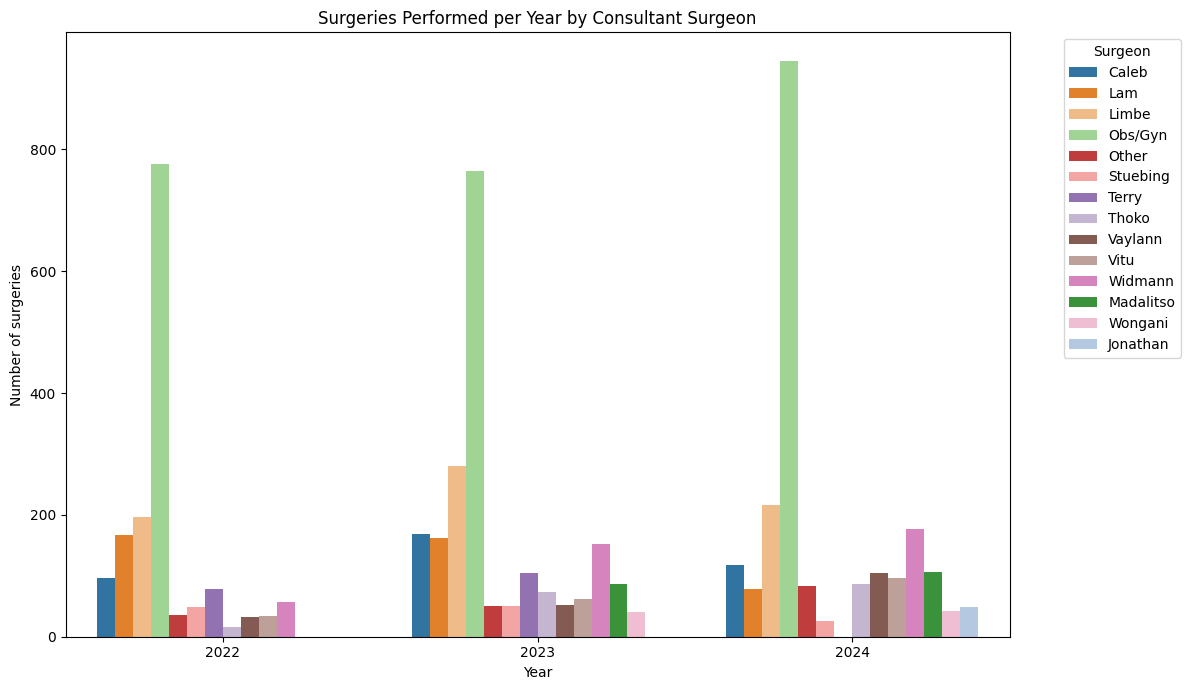

In [30]:
plt.figure(figsize=(12, 7))

sns.barplot(
    data=year_surgeon_counts,
    x="year",
    y="surgeries",
    hue="surgeon",
    palette=palette,
)

plt.xlabel("Year")
plt.ylabel("Number of surgeries")
plt.title("Surgeries Performed per Year by Consultant Surgeon")

plt.legend(
    title="Surgeon",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()
